# Detection of an unknown pulsar and measurement of its period

In [2]:
# Preamble and imports
from __future__ import (print_function, absolute_import, division)

import os
import numpy as np
from  matplotlib import pyplot as plt
import matplotlib
from math import pi
from scipy.signal import find_peaks

%matplotlib inline

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

## 1. Importing Data

In [3]:
# Get the directory with the data
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "DataSP", "FFT")

def get_header(file_name):
    """
    Function that reads in the header files.
    
    @param file_name :: name of the file
    
    @returns :: contents of header file as array
                of lines
    """
    
    file_name = file_name + '.hdr'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        lines = dfile.readlines()
        for i, line in enumerate(lines):
            lines[i] = line.strip()
    
    return lines


def get_data(file_name):
    """
    Function that returns the data in the files.
    
    @param file_name :: name of the file
    
    @returns :: contents of the data file
                in one numpy array
    """
    
    file_name = file_name + '.dat'
    data_file = os.path.join(data_dir, file_name)
    with open(data_file) as dfile:
        data = np.fromfile(dfile, dtype='b')
    
    return data

## 2. Fourier Transform Demo Plots and Data

In [4]:
def generate_times(dt, npts):
    """
    Generate the times for the demo.
    
    @param dt :: interval between times
    @param npts :: number of time points
    
    @returns :: array of times
    """

    times = np.linspace(0,(npts-1)*dt,npts)
    
    return times

def generate_signal(times, period):
    """
    Generates the fake signal.
    
    @param times :: array of times
    @param period :: period of the signal
    
    @returns :: fake signal
    """
    
    fake_signal = np.sin(2*pi*times/period)
    
    return fake_signal
    
def generate_noise(npts):
    """
    Generates random noise.
    
    @param npts :: number of points
    
    @returns :: random distributed noise
    """
    
    random_noise = np.random.normal(0,20,npts)
    
    return random_noise

## 2.1 Plotting

In [5]:
def raw_plot(times, raw_bytes, fake_signal):
    """
    Plots the raw simulated data with the signal.
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with the data
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Simulated noise plus sinusoidal signal")


def signal_plot(times, raw_bytes, fake_signal):
    """
    Signal plot of the data (zoomed in)
    
    @param times :: array of times
    @param raw_bytes :: array of data
    @param fake_signal :: fake signal data
    
    @returns :: plot of the signal with data zoomed in
    """
    
    plt.figure(figsize=(10,3))
    plt.plot(times, raw_bytes)
    plt.plot(times, fake_signal, color='red', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Zoomed to show signal amplitude")
    plt.xlim(0,5)
    plt.ylim(-3,3)
    
def time(data_header, data):
    """
    Plots the input data as a function of time
    
    @data_header :: header file with info about "sampling_perion"
    @data :: file with the input data
    
    @return :: plot of the amplitude as a function of time
            :: integration time
    """
    sampling_period = float(data_header[-2][5:-1])              # period over which the data is sampled (ms)
    int_time        = sampling_period*len(data)*(pow(10, -3))   # time required for integration
    period_array    = np.linspace(0, int_time, num=len(data))   # linearly spaced time array
    
    plt.figure(figsize=(10,3))
    plt.plot(period_array, data, color = 'green', linewidth=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    
    return int_time

## 3. Fourier Transforms

## 4. Kowalsky, Analysis.

### 4.1 Simulation of data

NameError: name 'fourier_transform' is not defined

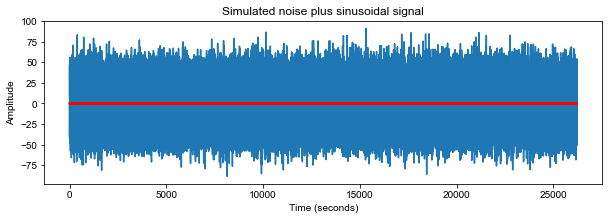

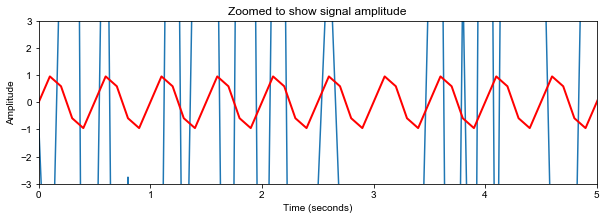

In [6]:
# Choose time interval and number of points
dt = 0.1
npts = 262144
period = 0.5

# Generate data
times           = generate_times(dt, npts)
fake_signal     = generate_signal(times, period)
noise           = generate_noise(npts)
raw_bytes       = noise + fake_signal

# Plot data
raw_plot(times, raw_bytes, fake_signal)
signal_plot(times, raw_bytes, fake_signal)
fourier_transform(raw_bytes)
   


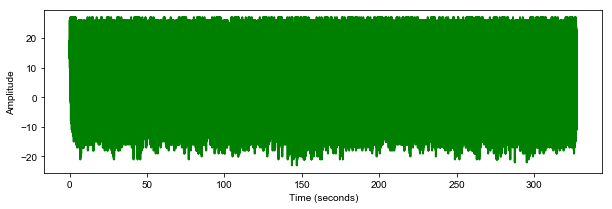

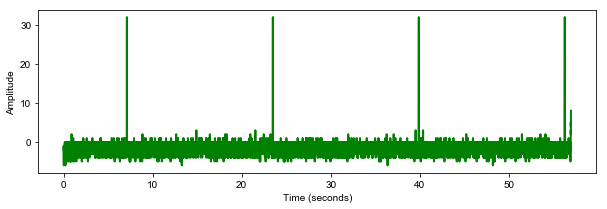

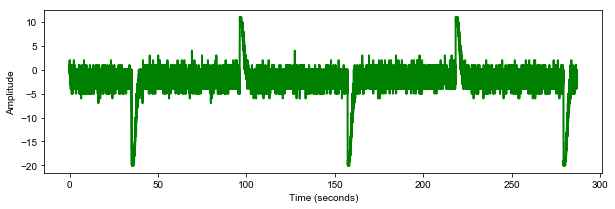

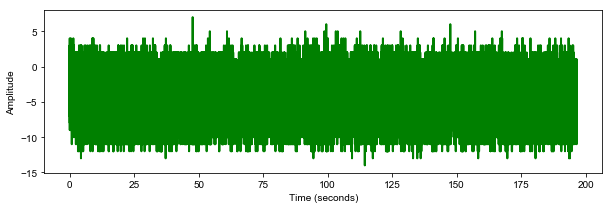

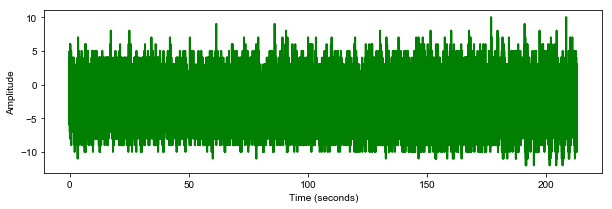

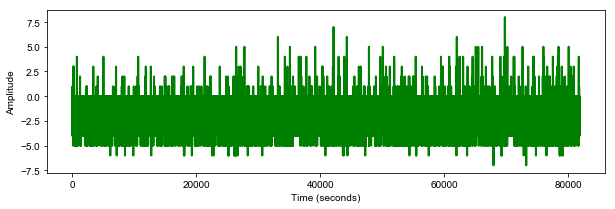

In [7]:
psr0 = get_data('psr0');
psr1 = get_data('psr1');
psr2 = get_data('psr2');
psr3 = get_data('psr3');
psr4 = get_data('psr4');
psr5 = get_data('psr5');

psr0_header = get_header('psr0');
psr1_header = get_header('psr1');
psr2_header = get_header('psr2');
psr3_header = get_header('psr3');
psr4_header = get_header('psr4');
psr5_header = get_header('psr5');

int_time0 = time(psr0_header, psr0)
int_time1 = time(psr1_header, psr1)
int_time2 = time(psr2_header, psr2)
int_time3 = time(psr3_header, psr3)
int_time4 = time(psr4_header, psr4)
int_time5 = time(psr5_header, psr5)


In [8]:
def fourier_transform(raw_bytes):
    """
    Fourier transforms data.
    
    @param raw_bytes :: the data
    
    @returns :: the power of the fourier transformed
                data
    """
    
    ft = np.fft.rfft(raw_bytes)
    power = np.real(ft)*np.real(ft) + np.imag(ft)*np.imag(ft)
    
    return power

def frequencyArray(power, int_time, limits):
    """
    Calculates the frequency array for the corresponding  power array
    Eliminates the regular spikes observed at 50 Hz :: Reason yet to be resolved
    
    @param power :: power array from the  fft
    @param int_time :: integration time for the corresponding pulsar
    
    @returns :: frequency array for the calibration of x-axis
    """
    # Starting point of the frequency array
    freq_start_pt   = 1/int_time                                
    freq_array = np.linspace(freq_start_pt, freq_start_pt*len(power), num=len(power))
   
    # k corresponding to the frequency to be eliminated
    for i in range(len(limits)):
        a = np.where(((freq_array >= limits[i][0]) & (freq_array <=limits[i][1]))) 
        freq_array = np.delete(freq_array, a)                        
        power = np.delete(power, a)  

    return freq_array, power
    
def findingPeaks_plot(dist, power, freq, x):
    """
    Function finds the peaks in the plot
    
    @param power :: power spectrum with peaks
    @param  dist :: allows to input minimum distance required between peaks
    @param     x :: pulsar number  
    
    @returns        :: Plot with the peaks
             period :: Period of the Pulsar with RFI            -|
          p_deleted :: RFI points in the period array            |--> result   
         period_new :: True array with only 'Period' points      |       
           outliers :: Gives the indicies of the outlier points _|                   
    """
    # finds the peaks and the period == distance between peaks
    peak, _ = find_peaks(power, distance=dist)
    period = 1/(np.diff(freq[peak]))
    
    # calculting the indicies and periods of the outliers
    idxOutliers     = np.where(abs(period - np.mean(period)) > 1 * np.std(period));
    periodOutliers  = period[idxOutliers];
    period_new      = np.delete(period, idxOutliers);
    
    # putting it all together
    result = np.array([period, idxOutliers, periodOutliers, period_new])
    
    # plots the data 
    plt.figure(figsize=(7,7))
    plt.plot(freq[peak], power[peak], "ro")
    plt.plot(freq, power, 'g-')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power spectrum: Pulsar {}".format(x))
    plt.tight_layout()
    return result, freq[peak]

def fitPlot(f_peak, x):
    """
    Function plots the frequency peaks vs the no. of harmonics
    
    @param f_peak :: peak frequency values
                x :: pulsar number
    """
    plt.figure(figsize=(7,7))
    plt.plot(f_peak, np.linspace(1, len(f_peak), num=len(f_peak)), "ro")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("No. of Harmonic")
    plt.title("Frequency vs No. of Harmonics: Pulsar {}".format(x))
    

def sliceAfter(f, p, m):
    """
    Function slices the arrays of frequency and power as per input value (m, n, & o)
    
    @param f :: Frequency arrays for the pulsar
    @param p :: Power arrays for the pulsar
    @param m :: frequency value at which the pulsars are sliced
    
    @returns f_ :: sliced frequency arrays
             p_ :: sliced power arrays  
    """
    # index values at which the arrays are being sliced
    idxDes = np.where(f < m);
    
    f_ = f[idxDes];
    p_ = p[idxDes];
    
    return f_, p_

def removeNoise(f1, p1, x):
    """
    Function removes the noise from pulsar 2
    
    @param      f1 :: freuency array of pulsar 2
    @param      p1 :: power array of pulsar 2
    
    @returns f1new :: new frequncy array with noise eliminated
             p1new :: new power array with noise eliminated        
    """
    idxKeep = np.where(p1 > x)
    p1new = p1[idxKeep]
    f1new = f1[idxKeep]
    
    return f1new, p1new

[array([0.22645473, 0.22661134, 0.22645473, 0.22661134, 0.22645473,
       0.22661134, 0.22645473, 0.22661134, 0.22645473, 0.34675132])
 (array([9], dtype=int64),) array([0.34675132])
 array([0.22645473, 0.22661134, 0.22645473, 0.22661134, 0.22645473,
       0.22661134, 0.22645473, 0.22661134, 0.22645473])]
[array([0.19000667, 0.18937542, 0.18937542, 0.18937542, 0.19000667,
       0.1868918 , 0.19000667, 0.18937542, 0.09468771, 0.19000667,
       0.18937542, 0.18937542, 0.18937542, 0.19000667, 0.1868918 ,
       0.15574317, 0.10634701, 0.10983044, 0.14883029, 0.18874834,
       0.19000667, 0.13936919, 0.12809438, 0.07808493, 0.10878244,
       0.12639024, 0.14039901, 0.16379885, 0.07431812, 0.17273333,
       0.12925624, 0.18628105, 0.16716129, 0.16147875, 0.15574317,
       0.15616986])
 (array([ 8, 16, 17, 23, 24, 28], dtype=int64),)
 array([0.09468771, 0.10634701, 0.10983044, 0.07808493, 0.10878244,
       0.07431812])
 array([0.19000667, 0.18937542, 0.18937542, 0.18937542, 0.190006

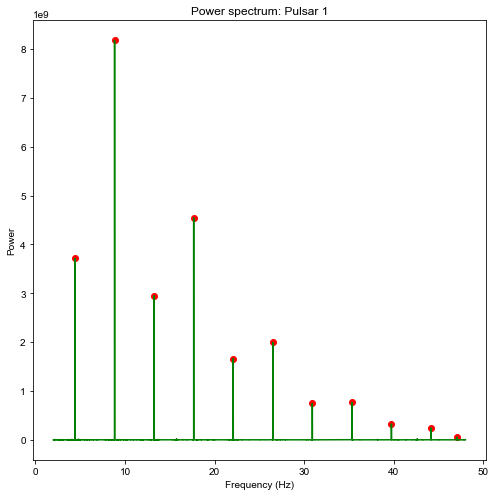

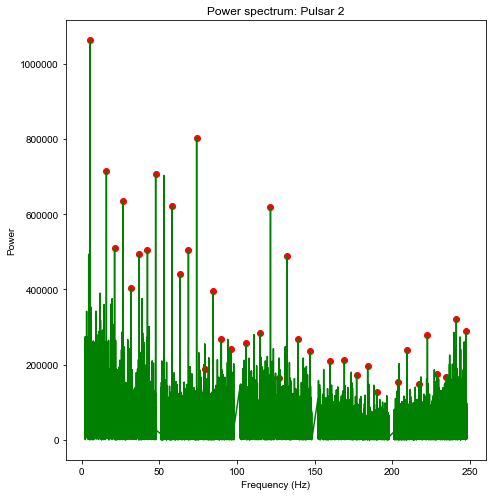

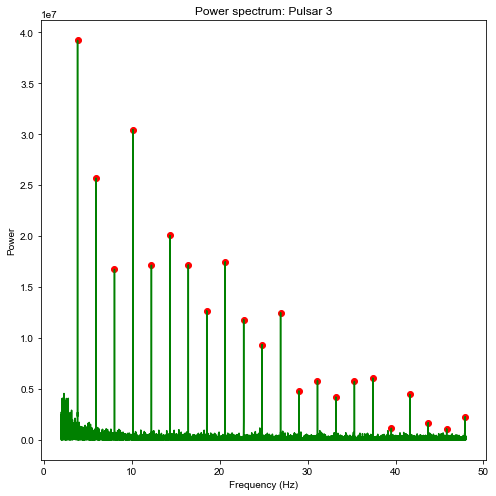

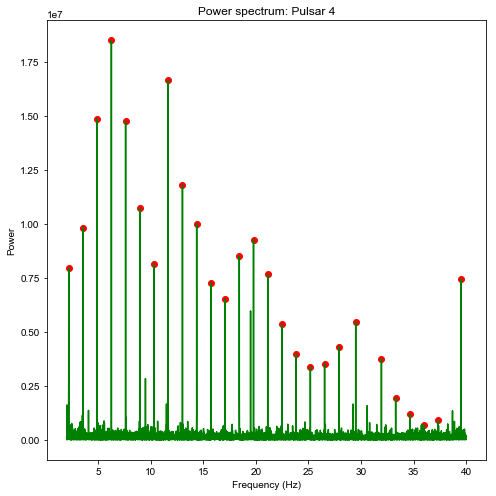

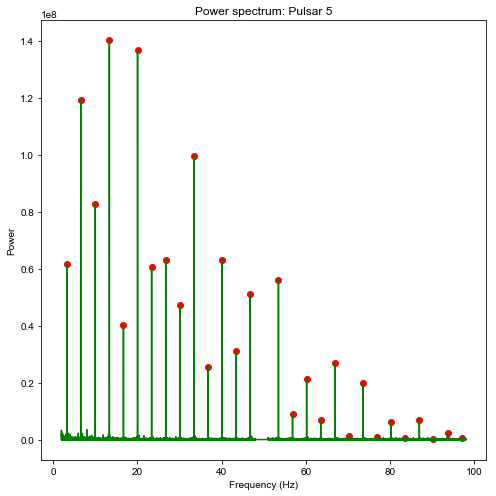

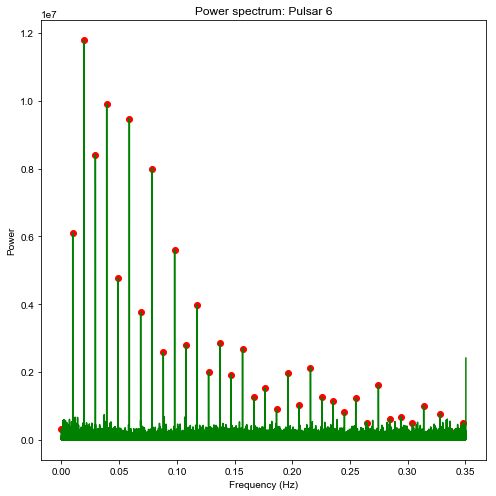

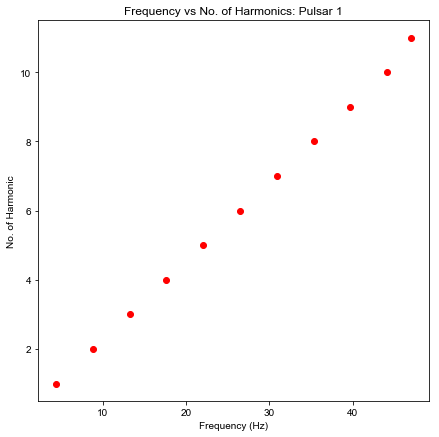

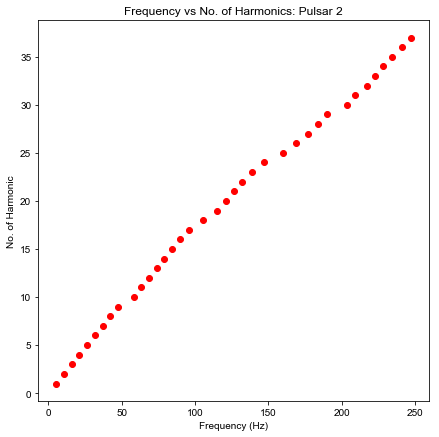

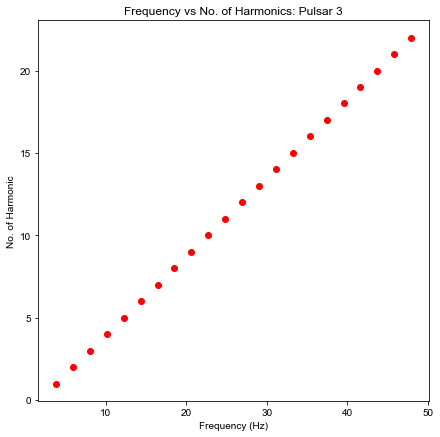

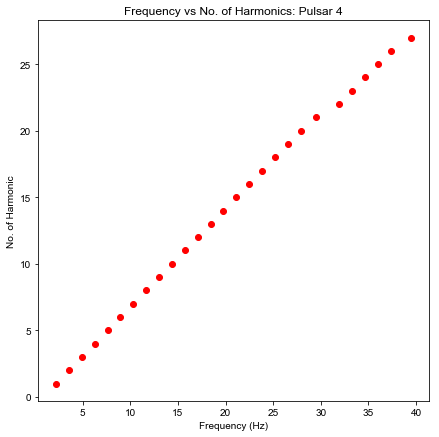

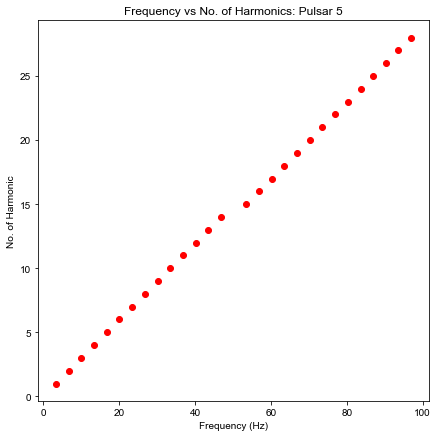

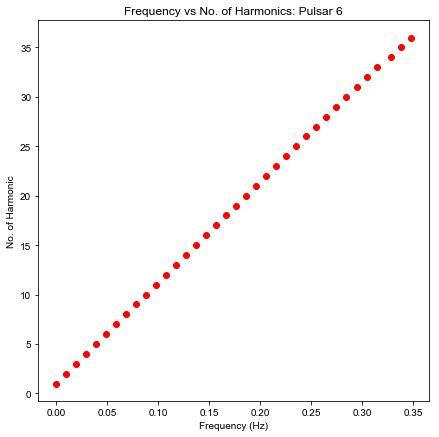

In [9]:
# calculates the power to plot the power spectrum using FFT
power0 = fourier_transform(psr0)[1:]
power1 = fourier_transform(psr1)[1:]
power2 = fourier_transform(psr2)[100:]
power3 = fourier_transform(psr3)[100:]
power4 = fourier_transform(psr4)[1:]
power5 = fourier_transform(psr5)[1:]

# eliminates suspicious cuts observed in the data
cuts = [[0, 2],[48, 51], [98,102],[148, 152],[198,201],[248, 251],[298, 301]]

# calcultes the frequency and power array to plot after elimiting cuts
freq0, power0 = frequencyArray(power0, int_time0, cuts)   
freq1, power1 = frequencyArray(power1, int_time1, cuts)
freq2, power2 = frequencyArray(power2, int_time2, cuts)
freq3, power3 = frequencyArray(power3, int_time3, cuts)
freq4, power4 = frequencyArray(power4, int_time4, cuts)
freq5, power5 = frequencyArray(power5, int_time5, cuts[1:])

# removes noise from pulsar 2
f1_, p1_ = removeNoise(freq1, power1, 100000)

# calculetes the points at which the arrays need to be sliced
f2_, p2_ = sliceAfter(freq2, power2, 50);
f3_, p3_ = sliceAfter(freq3, power3, 40);
f4_, p4_ = sliceAfter(freq4, power4, 100);
                                          
   
# finds the periods, outlier's false harmonic, period of the outlier, new_period array
result0, f_peak0      = findingPeaks_plot(900, power0, freq0, '1')

result1i, f_peak1i    = findingPeaks_plot(300, power1, freq1, '2')
#result1ii, f_peak1ii  = findingPeaks_plot(10, p1_, f1_, '2')

#result2, f_peak2i     = findingPeaks_plot(600, power2, freq2, '3')
result2, f_peak2ii    = findingPeaks_plot(600, p2_, f2_, '3')

#result3, f_peak3i     = findingPeaks_plot(250, power3, freq3, '4')
result3, f_peak3ii    = findingPeaks_plot(250, p3_, f3_, '4')

#result4, f_peak4i     = findingPeaks_plot(700, power4, freq4, '5')
result4, f_peak4ii    = findingPeaks_plot(700, p4_, f4_, '5')

result5, f_peak5      = findingPeaks_plot(800, power5, freq5, '6')

# plots the frequency as a function of the No. of Harmonic
fitPlot(f_peak0, '1')

fitPlot(f_peak1i, '2')
#fitPlot(f_peak1ii, '2')

#fitPlot(f_peak2i, '3')
fitPlot(f_peak2ii, '3')

#fitPlot(f_peak3i, '4')
fitPlot(f_peak3ii, '4')

#fitPlot(f_peak4i, '5')
fitPlot(f_peak4ii, '5')

fitPlot(f_peak5, '6')

print(result0)
print(result1i)
print(result2)
print(result3)
print(result4)
print(result5)